![title](https://media.licdn.com/dms/image/C4D1BAQHrb5OViIi3QQ/company-background_10000/0?e=2159024400&v=beta&t=s-4EEblC_aodYcO6vS-i7KiAPk4YN5WKWEYA91DDQrw)

# <center>Connaître l'offre gastronomique et touristique de la ville de Lyon: un cas pratique de Data Intelligence et Machine Learning pour l'analyse des comportements sociaux avec Google Maps</center>

 <center> <a href="http://www.roqueleal.me">Roque Leal</a> </center>

A cette occasion, nous allons effectuer une étude exploratoire des données Google Maps associées à la ville de Lyon, pour cela nous utiliserons l'extraction de données dans Google Maps pour découvrir des données utiles sur les restaurants ou leurs attractions touristiques: noms, types entreprise, nombre d'étoiles, coordonnées, heures les plus fréquentées, etc.

Toutes ces données peuvent être utilisées pour obtenir beaucoup de connaissances sur l'entreprise / l'emplacement et ses environs, pour cela, nous commençons cette promenade avec quelque chose du plus typique de Lyon: sa gastronomie et ses attractions touristiques pour découvrir des Geoinsights intéressants des restaurants, améliorer la l'expérience client, connaître leur comportement et répondre à notre curiosité pour savoir le mieux que la ville nous offre de manière intelligente avec BigData et Data Science.

## Bibliothèques Python

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementNotInteractableException, ElementClickInterceptedException
from tqdm import tqdm_notebook as tqdmn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import time, re

## Nous extrayons les données pour les analyser

In [10]:
resto = pd.read_csv('lyon_resto.csv')

In [11]:
resto.head()

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,hours,latitude,longitude
0,Canaima Restaurant,5.0,(40),Restaurant,NaN,"QR9M+WP Lyon, France",NaN,+33 9 87 05 87 25,"['cuisine\n11', 'service\n3']",[],45.769869,4.834309
1,Tipico - Restaurant & Épicerie Conviviale,5.0,(62),Italian restaurant,NaN,"QR9H+7J Lyon, France",NaN,+33 4 72 02 29 91,"['entrees\n4', 'wine\n4', 'patterns\n3', 'hear...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.768148,4.829084
2,POP KORNER,4.9,(90),Restaurant,NaN,"QRCM+FJ Lyon, France",NaN,+33 4 69 84 55 76,"['concept\n18', 'cinema\n14', 'room\n8', 'blin...","['% busy at .', '% busy at .', '% busy at .', ...",45.771130,4.834113
3,L'Atelier des Augustins,4.7,(275),French restaurant,$$,"QR9J+39 Lyon, France",NaN,+33 4 72 00 88 01,"['surprise\n38', 'wine\n37', 'chef\n22', 'food...",[],45.767739,4.830911
4,BEL AMI,4.7,(155),Restaurant,NaN,"QR9J+F3 Lyon, France",NaN,NaN,"['tapas\n25', 'cuisine\n14', 'wine list\n10', ...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.768699,4.830235


In [12]:
resto.shape

(199, 12)

## Cette technique de Geo Datamining nous permet d'extraire les données de 199 restaurants de la ville de Lyon

In [13]:
resto.total_ratings = resto.total_ratings.replace('(\(|\)|,)', '', regex=True)

In [14]:
resto.total_ratings = resto.total_ratings.astype(float)

In [15]:
resto.business_category.value_counts()

Restaurant                        73
French restaurant                 41
Lebanese restaurant                6
Haute French restaurant            5
Fast food restaurant               4
Italian restaurant                 4
Japanese restaurant                4
Pizza restaurant                   3
Mexican restaurant                 3
Brasserie                          2
American restaurant                2
Asian restaurant                   2
Vegan restaurant                   2
Bar                                2
Down home cooking restaurant       2
Indian restaurant                  2
Modern French restaurant           2
Vegetarian restaurant              2
Moroccan restaurant                2
Hamburger restaurant               2
Seafood restaurant                 1
Hot pot restaurant                 1
Pizza takeaway                     1
Alsace restaurant                  1
Fine dining restaurant             1
Tapas bar                          1
Korean restaurant                  1
A

Nous voulons conserver uniquement les établissements qui sont des steakhouses, des bars et des grillades ou des restaurants ayant le nom «steak» ou «grill» dans leurs noms. Appelons ce nouveau dataframe SBR (pour les Steakhouses, les Bar & Grills et les Restaurants):

## Nous localiserons notre échantillon de 199 restaurants à Lyon

In [16]:
tileset = r'https://api.mapbox.com/styles/v1/roqueleal08/cjyaey84d07zq1crze5r08yg1/tiles/256/{z}/{x}/{y}@2x?access_token=pk.APIMAPBOX'
attribution = (r'Map data © <a href="http://openstreetmap.org">OpenStreetMap</a>'
                ' contributors, Imagery © <a href="http://mapbox.com">MapBox</a>')
gdl_center = [45.756146,4.835014]
resto_map = folium.Map(location=gdl_center, zoom_start=12.5, tiles=tileset, attr=attribution)

for latitude, longitude, full_name, address, phone, website, rating, total_rating in zip(resto.latitude, resto.longitude, resto.full_name, resto.address, resto.phone, resto.website, resto.rating, resto.total_ratings):
    popup = '<strong>' + str(full_name) +  '</li><li>Rating: ' + str(rating) + ' (Total of ' + str(total_rating) + ' reviews)'
    folium.Marker( [latitude, longitude], 
                   icon=folium.CustomIcon( icon_image='https://www.pinclipart.com/picdir/big/46-460577_maps-vector-graphic-google-maps-icon-android-clipart.png', icon_size=(15,15) ), popup=popup).add_to(resto_map)
resto_map

In [17]:
from folium.plugins import HeatMap
resto_rating = resto[resto.total_ratings>400].copy()
resto_rating['count'] = 1

## Nous faisons un Heatmap avec les restaurants avec le meilleur score de reviews de la ville

In [18]:
HeatMap(data=resto_rating[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=20, max_zoom=17).add_to(resto_map)
resto_map

In [24]:
resto_rating.head().sort_values(by='total_ratings', ascending=False)

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,hours,latitude,longitude,count
25,YAAFA,4.4,987.0,Fast food restaurant,NaN,NaN,yaafa.fr,"QR9J+2M Lyon, France","['delivery\n4', 'falafel\n174', 'corn\n29', 'r...","['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...",45.767578,4.831731,1
15,Le Bouchon des Filles,4.4,789.0,Restaurant,$$,"QR9H+FP Lyon, France",NaN,+33 4 78 30 40 44,"['food presentation\n60', 'entree\n50', 'lyonn...","['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...",45.768673,4.829360,1
16,Delicatessen,4.6,626.0,Restaurant,$$,NaN,facebook.com,"QR9H+QV Lyon, France","['concept\n71', 'amateur\n23', 'weight\n17', '...","['% busy at .', '0% busy at 6 AM.', '0% busy a...",45.769481,4.829663,1
5,La Mère Brazier,4.7,574.0,Restaurant,$$$$,"QRCP+HV Lyon, France",NaN,+33 4 78 23 17 20,"['food presentation\n66', 'corn\n21', 'sommeli...",[],45.771443,4.837213,1
14,La Tête De Lard,4.4,501.0,Restaurant,$$,"QR9P+86 Lyon, France",NaN,+33 4 78 27 96 80,"['bouchon\n95', 'food presentation\n23', 'entr...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.768369,4.835512,1


## Maintenant, nous identifions les restaurants qui remplissent la condition d'être des restaurants de cuisine traditionnelle de haute qualité avec une bonne gamme de cocktails

Ici, nous voyons les restaurants qui remplissent les conditions décrites en fonction du sujet de leurs avis, cela fait référence aux mots clés que les utilisateurs ont reconnus et attribués à leurs "reviews". Avec ces données, nous choisissons les restaurants qui remplissent la condition de "traditionnel", "cocktail" et "présentation" pour attribuer une valeur à chaque restaurant et obtenir un score en fonction de ces conditions.

In [26]:
traditional = []
for i in resto.review_topics :
    traditional.append(re.findall('\d+|$', re.findall('traditional......|$', i)[0])[0] )

resto['traditional'] = traditional

cocktail = []
for i in resto.review_topics :
    cocktail.append(re.findall('\d+|$', re.findall('cocktail......|$', i)[0])[0] )

resto['cocktail'] = cocktail

presentation = []
for i in resto.review_topics :
    presentation.append(re.findall('\d+|$', re.findall('presentation......|$', i)[0])[0] )

resto['presentation'] = presentation

In [29]:
resto.head()

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,hours,latitude,longitude,traditional,cocktail,presentation
0,Canaima Restaurant,5.0,40.0,Restaurant,NaN,"QR9M+WP Lyon, France",NaN,+33 9 87 05 87 25,"['cuisine\n11', 'service\n3']",[],45.769869,4.834309,,,
1,Tipico - Restaurant & Épicerie Conviviale,5.0,62.0,Italian restaurant,NaN,"QR9H+7J Lyon, France",NaN,+33 4 72 02 29 91,"['entrees\n4', 'wine\n4', 'patterns\n3', 'hear...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.768148,4.829084,,,
2,POP KORNER,4.9,90.0,Restaurant,NaN,"QRCM+FJ Lyon, France",NaN,+33 4 69 84 55 76,"['concept\n18', 'cinema\n14', 'room\n8', 'blin...","['% busy at .', '% busy at .', '% busy at .', ...",45.771130,4.834113,,6,
3,L'Atelier des Augustins,4.7,275.0,French restaurant,$$,"QR9J+39 Lyon, France",NaN,+33 4 72 00 88 01,"['surprise\n38', 'wine\n37', 'chef\n22', 'food...",[],45.767739,4.830911,,,20
4,BEL AMI,4.7,155.0,Restaurant,NaN,"QR9J+F3 Lyon, France",NaN,NaN,"['tapas\n25', 'cuisine\n14', 'wine list\n10', ...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.768699,4.830235,,,


In [33]:
resto.traditional = resto.traditional.replace('', 0)
resto.cocktail = resto.cocktail.replace('', 0)
resto.presentation = resto.presentation.replace('', 0)

In [34]:
resto.traditional = resto.traditional.astype(int)
resto.cocktail = resto.cocktail.astype(int)
resto.presentation = resto.presentation.astype(int)

In [36]:
resto.head()

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,hours,latitude,longitude,traditional,cocktail,presentation
0,Canaima Restaurant,5.0,40.0,Restaurant,NaN,"QR9M+WP Lyon, France",NaN,+33 9 87 05 87 25,"['cuisine\n11', 'service\n3']",[],45.769869,4.834309,0,0,0
1,Tipico - Restaurant & Épicerie Conviviale,5.0,62.0,Italian restaurant,NaN,"QR9H+7J Lyon, France",NaN,+33 4 72 02 29 91,"['entrees\n4', 'wine\n4', 'patterns\n3', 'hear...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.768148,4.829084,0,0,0
2,POP KORNER,4.9,90.0,Restaurant,NaN,"QRCM+FJ Lyon, France",NaN,+33 4 69 84 55 76,"['concept\n18', 'cinema\n14', 'room\n8', 'blin...","['% busy at .', '% busy at .', '% busy at .', ...",45.771130,4.834113,0,6,0
3,L'Atelier des Augustins,4.7,275.0,French restaurant,$$,"QR9J+39 Lyon, France",NaN,+33 4 72 00 88 01,"['surprise\n38', 'wine\n37', 'chef\n22', 'food...",[],45.767739,4.830911,0,0,20
4,BEL AMI,4.7,155.0,Restaurant,NaN,"QR9J+F3 Lyon, France",NaN,NaN,"['tapas\n25', 'cuisine\n14', 'wine list\n10', ...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.768699,4.830235,0,0,0


In [37]:
resto['score'] = resto.traditional + resto.cocktail + resto.presentation

In [38]:
resto[((resto.traditional != 0)|(resto.cocktail != 0)) & (resto.presentation != 0)].sort_values(by='score', ascending=False)

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,hours,latitude,longitude,traditional,cocktail,presentation,score
31,Maison Villemanzy,4.4,352.0,French restaurant,$$,"QRCP+M7 Lyon, France",NaN,+33 4 72 98 21 21,"['food presentation\n41', 'terrace\n26', 'visi...","['% busy at .', '0% busy at 6 AM.', '0% busy a...",45.771666,4.835712,5,0,41,46
152,La Mère Jean,4.4,656.0,French restaurant,$$,"QR4M+WX Lyon, France",NaN,+33 4 78 37 81 27,"['bouchon\n124', 'food presentation\n31', 'lyo...","['% busy at .', '0% busy at 6 AM.', '0% busy a...",45.757263,4.834922,9,0,31,40
85,Butcher,4.4,468.0,Restaurant,$$,"QR8J+5Q Lyon, France",NaN,+33 9 50 76 46 82,"['burger\n52', 'corn\n34', 'food presentation\...","['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...",45.765452,4.831978,0,19,20,39
135,Copper Roots,4.5,103.0,Restaurant,NaN,"QRGP+PF Lyon, France",NaN,+33 4 72 07 64 30,"['cocktails\n32', 'brunch\n13', 'cuisine\n11',...","['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...",45.776758,4.836198,0,32,7,39
101,Bouchon Tupin,4.8,366.0,French restaurant,$$,"QR7M+5X Lyon, France",NaN,+33 4 78 37 45 93,"['food presentation\n29', 'server\n18', 'parfa...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.762878,4.834945,8,0,29,37
50,Mas amor por favor,4.2,186.0,Restaurant,$$,NaN,masamorporfavor-lyon.com,"QR9J+X3 Lyon, France","['brunch\n27', 'cocktails\n27', 'cuisine\n14',...",[],45.769906,4.830210,0,27,5,32
9,Sabaï Sabaï,4.7,166.0,Asian restaurant,$$,NaN,sabaisabai.fr,"QR9P+PM Lyon, France","['tapas\n31', 'food presentation\n17', 'cockta...","['% busy at .', '0% busy at 6 AM.', '0% busy a...",45.769259,4.836668,0,13,17,30
127,Restaurant El Cafetero,4.6,200.0,Restaurant,$$,"QRCX+2P Lyon, France",NaN,NaN,"['food presentation\n20', 'mojito\n11', 'colom...",[],45.770115,4.849329,0,6,20,26
78,Le Passage,4.4,217.0,Restaurant,$$,"QR8M+9G Lyon, France",NaN,+33 4 78 28 11 16,"['cuisine\n18', 'food presentation\n14', 'cock...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.765999,4.833757,0,9,14,23
28,Hemingway's,4.3,235.0,Restaurant,$$,NaN,hemingways.fr,"QRCP+5Q Lyon, France","['cuisine\n14', 'cocktails\n13', 'server\n12',...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.770390,4.836936,0,13,9,22


## Nous avons 13 restaurants qui remplissent cette condition, nous allons maintenant étendre l'offre et sélectionner également ceux qui offrent une bonne qualité à un prix abordable

In [41]:
resto.price_range = resto.price_range.replace({'$$':'Affordable', '$$$':'Pricy' })

In [42]:
resto_best = resto.head(30).sort_values(by='score', ascending=False)

In [51]:
resto_best.head()

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,hours,latitude,longitude,traditional,cocktail,presentation,score
5,La Mère Brazier,4.7,574.0,Restaurant,$$$$,"QRCP+HV Lyon, France",NaN,+33 4 78 23 17 20,"['food presentation\n66', 'corn\n21', 'sommeli...",[],45.771443,4.837213,0,0,66,66
15,Le Bouchon des Filles,4.4,789.0,Restaurant,Affordable,"QR9H+FP Lyon, France",NaN,+33 4 78 30 40 44,"['food presentation\n60', 'entree\n50', 'lyonn...","['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...",45.768673,4.829360,0,0,60,60
9,Sabaï Sabaï,4.7,166.0,Asian restaurant,Affordable,NaN,sabaisabai.fr,"QR9P+PM Lyon, France","['tapas\n31', 'food presentation\n17', 'cockta...","['% busy at .', '0% busy at 6 AM.', '0% busy a...",45.769259,4.836668,0,13,17,30
23,Le Cochon Qui Boit,4.5,356.0,French restaurant,Affordable,"QRCP+7X Lyon, France",NaN,+33 4 78 27 23 37,"['food presentation\n25', 'being\n15', 'entree...",[],45.770644,4.837389,0,0,25,25
29,Les Filaos Restaurant réunionnais,4.3,351.0,Restaurant,Affordable,NaN,lesfilaos-lyon.com,"QR9H+PQ Lyon, France","['corn\n26', 'food presentation\n24', 'terrace...","['% busy at .', '% busy at .', '0% busy at 6 A...",45.769291,4.829473,0,0,24,24


In [44]:
resto_best.shape

(30, 16)

## Cette nouvelle consultation nous a permis d'élargir notre offre à 30 restaurants, dont La Mère Brazier est l'endroit le plus attractif pour choisir et prendre un bon dîner en ville.

## Nous trouverons les meilleurs restaurants de haute qualité dans la cuisine traditionnelle avec une bonne gamme de cocktails et des prix abordables

In [47]:
from folium.plugins import HeatMap
score = resto_best[resto_best.score>11].copy()
score['count'] = 1

In [48]:
HeatMap(data=score[['latitude', 'longitude', 'score']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=20, max_zoom=17).add_to(resto_map)
resto_map

## Connaître le meilleur moment pour visiter notre restaurant

Grâce à l'analyse de l'offre gastronomique lyonnaise, nous avons pu choisir Le Bouchon des Filles et aussi nous connaissons sa localisation, nous allons donc extraire les données du Popular Times de Google Maps pour connaître le meilleur moment pour la visiter.

Avec Google Popular Times, nous pouvons connaître en temps réel l'occupation d'une entreprise, en l'occurrence par Le Bouchon des Filles, avec cela il est possible de connaître les données sur les visites et la durée habituelle des visites dans les locaux.

![title](https://uploads.guim.co.uk/2016/11/22/Google-Maps-live-data-crop-compressor2.gif)


## On extrait les données sur la durée habituelle des visites dans Le Bouchon des Filles

In [52]:
str(list(resto_best[resto_best.full_name == 'Le Bouchon des Filles'].hours))

'["[\'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'0% busy at 8 AM.\', \'0% busy at 9 AM.\', \'0% busy at 10 AM.\', \'0% busy at 11 AM.\', \'44% busy at 12 PM.\', \'68% busy at 1 PM.\', \'0% busy at 2 PM.\', \'0% busy at 3 PM.\', \'0% busy at 4 PM.\', \'0% busy at 5 PM.\', \'0% busy at 6 PM.\', \'40% busy at 7 PM.\', \'81% busy at 8 PM.\', \'85% busy at 9 PM.\', \'0% busy at 10 PM.\', \'0% busy at 11 PM.\', \'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'0% busy at 8 AM.\', \'0% busy at 9 AM.\', \'0% busy at 10 AM.\', \'0% busy at 11 AM.\', \'0% busy at 12 PM.\', \'0% busy at 1 PM.\', \'0% busy at 2 PM.\', \'0% busy at 3 PM.\', \'0% busy at 4 PM.\', \'0% busy at 5 PM.\', \'0% busy at 6 PM.\', \'30% busy at 7 PM.\', \'49% busy at 8 PM.\', \'51% busy at 9 PM.\', \'0% busy at 10 PM.\', \'0% busy at 11 PM.\', \'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'0% busy at 8 AM.\', \'0% busy at 9 AM.\', \'0% busy at 10 AM.\', \'0% busy at 11 AM.\', \'0% busy at 12 PM.\', \'0% busy at 1 PM.\', \'0% bu

In [90]:
def visit_planner(place_name) :

    place_name = pd.DataFrame(index=['Le dimanche', 'Le lundi', 'Le mardi', 'Le mercredi', 'Le jeudi', 'Le vendredi', 'Le samendi'], \
                              columns=['6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM','3 PM',
                                       '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'])    
    

    return place_name

In [55]:
base_resto = visit_planner('Le Bouchon des Filles')
base_resto

,6 AM,7 AM,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,11 PM
Le dimanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le lundi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le mardi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le mercredi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le jeudi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le vendredi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le samendi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
for hour in list(base_resto):
    base_resto[hour] = re.findall('...%.{0,20} '+str(hour), str(list(resto_best[resto_best.full_name=='Le Bouchon des Filles'].hours)))
    base_resto[hour] = [ re.findall('\d+', str(i))[0] for i in base_resto[hour] ]
    base_resto[hour] = base_resto[hour].astype(int)

In [58]:
base_resto

,6 AM,7 AM,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,11 PM
Le dimanche,0,0,0,0,0,0,44,68,0,0,0,0,0,40,81,85,0,0
Le lundi,0,0,0,0,0,0,0,0,0,0,0,0,0,30,49,51,0,0
Le mardi,0,0,0,0,0,0,0,0,0,0,0,0,0,15,40,56,0,0
Le mercredi,0,0,0,0,0,0,0,0,0,0,0,0,0,23,55,66,0,0
Le jeudi,0,0,0,0,0,0,0,0,0,0,0,0,0,35,66,73,0,0
Le vendredi,0,0,0,0,0,0,18,37,0,0,0,0,0,33,62,80,0,0
Le samendi,0,0,0,0,0,0,40,73,0,0,0,0,0,58,87,100,0,0


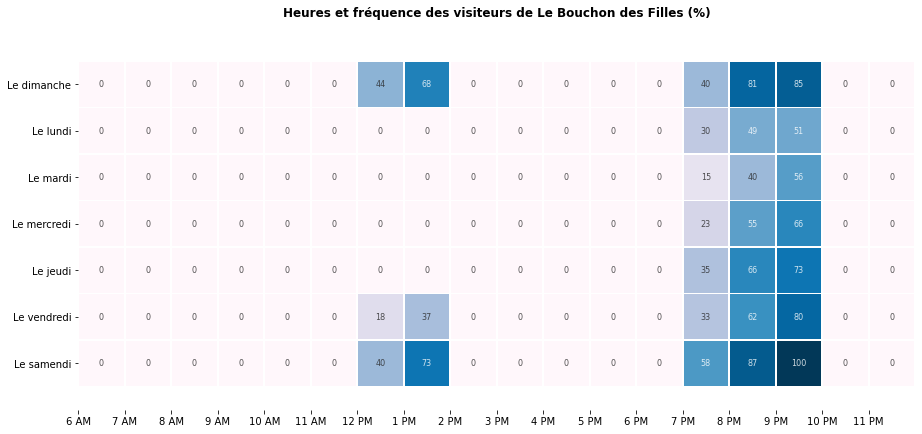

In [60]:
plt.figure(figsize=(15,7))
sns.heatmap(base_resto, cmap='PuBu', linewidths=0.8, annot=True, annot_kws={'fontsize':8, 'alpha':0.8}, fmt='d', square=True,
           cbar=False)

plt.xticks(np.arange(18), list(base_resto))
plt.title('Heures et fréquence des visiteurs de Le Bouchon des Filles (%)\n', weight='semibold')

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);
plt.show()

Grâce au Popular Times de Google Maps, nous avons découvert que Le Bouchon des Filles est ouvert tous les jours avec une fréquence très particulière dans ses heures, ce qui se traduit par une forte demande de visiteurs aux heures du déjeuner et du dîner, d'après ces résultats, je pense que Il est possible de profiter d'un excellent déjeuner en semaine car le week-end, il semble être encombré de clients, sauf si vous pouvez envisager d'aller déjeuner le week-end où la fréquence des visites est moindre.

Comme on peut le voir, ces données offrent un grand potentiel pour analyser le comportement des concurrents ainsi que pour connaître la structure des clients non seulement dans le secteur du tourisme mais dans n'importe quel secteur du commerce et des services.

En fait, vous pouvez en voir un exemple dans l'un de mes articles, cette fois pour Mexico où nous avons analysé spatialement Google Maps Popular Times <a href="https://www.roqueleal.me/big-data/popular-times-lyon.html">Disponible ici</a>

# Où sont les attractions touristiques de la ville de Lyon et quelles sont les heures les plus fréquentées

![title](https://www.appart-ambiance.com/images/lyon5big.jpg)

# Nous analyserons les données obtenues et trouverons le meilleur moment pour les visiter

In [69]:
HL = pd.read_csv('lyon_touristme.csv')

In [70]:
HL.shape

(104, 9)

### Les techniques de datamining nous ont permis d'avoir des données pour 108 attractions touristiques de Lyon

In [71]:
HL.total_ratings = HL.total_ratings.replace('\(|\)|,', '', regex=True)

In [72]:
HL.total_ratings = HL.total_ratings.astype(float)

In [73]:
HL10 = HL.sort_values(by='total_ratings', ascending=False).head(50).copy()

Selon leur popularité, ils sont commandés de cette façon

In [75]:
HL10.head(20)

,full_name,rating,total_ratings,landmark_category,description,address,hours,latitude,longitude
2,Parc de la Tête d'Or,4.6,37941.0,Park,"Vast, 19th-century park with statues, fountain...","69006 Lyon, France",[],45.783707,4.851606
1,La Basilique Notre Dame de Fourvière,4.7,19139.0,Basilica,"19th-century basilica with 4 octagonal towers,...","8 Place de Fourvière, 69005 Lyon, France","['0% busy at 6 AM.', '2% busy at 7 AM.', '4% b...",45.762293,4.822626
4,Cathédrale Saint-Jean-Baptiste,4.6,8777.0,Cathedral,Medieval cathedral with a 14th-century astrono...,"Place Saint-Jean, 69005 Lyon, France","['0% busy at 6 AM.', '0% busy at 7 AM.', '10% ...",45.760801,4.827290
12,Place des Jacobins,4.4,7125.0,Historical landmark,City square with an elaborate fountain & surro...,"Place des Jacobins, 69002 Lyon, France","['1% busy at 4 AM.', '1% busy at 5 AM.', '0% b...",45.760465,4.833427
8,Museum of Cinema Miniature,4.7,6188.0,Museum,"Museum of hyper-realistic, miniature everyday ...","60 Rue Saint-Jean, 69005 Lyon, France",[],45.761876,4.827347
50,Parc de Parilly,4.3,5141.0,Park,"178-hectare green space with woodland, an athl...","36 Boulevard Emile Bollaert, 69500 Bron, France","['0% busy at 6 AM.', '2% busy at 7 AM.', '26% ...",45.724180,4.897767
33,Museum of Fine Arts of Lyon,4.5,4432.0,Art museum,"Art museum in former 17th-century abbey, with ...","20 Place des Terreaux, 69001 Lyon, France","['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...",45.767110,4.833619
103,Bird Park,4.5,4125.0,Animal park,Park with huge bird collection including rare ...,"D1083, 01330 Villars-les-Dombes, France",[],45.991759,5.025966
38,Parc Sergent Blandan,4.3,3930.0,Park,Sizable city park on the site of onetime army ...,"37 Rue du Repos, 69007 Lyon, France",[],45.745637,4.854416
25,Halles de Lyon Paul Bocuse,4.6,3843.0,Fresh food market,NaN,"102 Cours Lafayette, 69003 Lyon, France","['0% busy at 6 AM.', '2% busy at 7 AM.', '25% ...",45.763344,4.850456


## Nous localisons les attractions sur une carte

In [78]:
tourisme_map = folium.Map(location=gdl_center, zoom_start=13, tiles=tileset, attr=attribution)

for latitude, longitude, full_name, rating, total_rating in zip(HL10.latitude, HL10.longitude, HL10.full_name, HL10.rating, HL10.total_ratings):
    popup = '<strong>' + str(full_name) +  '</li><li>Rating: ' + str(rating) + ' (Total of ' + str(total_rating) + ' reviews)'
    folium.Marker( [latitude, longitude], 
                   icon=folium.CustomIcon( icon_image='https://www.pinclipart.com/picdir/big/46-460577_maps-vector-graphic-google-maps-icon-android-clipart.png', icon_size=(15,15) ), popup=popup).add_to(tourisme_map)
tourisme_map

Nous créons maintenant une carte thermique avec les attractions touristiques les plus populaires

In [85]:
tourisme_rating = HL10[HL10.total_ratings>2000].copy()
tourisme_rating['count'] = 1

In [86]:
tourisme_rating.head(50)

,full_name,rating,total_ratings,landmark_category,description,address,hours,latitude,longitude,count
2,Parc de la Tête d'Or,4.6,37941.0,Park,"Vast, 19th-century park with statues, fountain...","69006 Lyon, France",[],45.783707,4.851606,1
1,La Basilique Notre Dame de Fourvière,4.7,19139.0,Basilica,"19th-century basilica with 4 octagonal towers,...","8 Place de Fourvière, 69005 Lyon, France","['0% busy at 6 AM.', '2% busy at 7 AM.', '4% b...",45.762293,4.822626,1
4,Cathédrale Saint-Jean-Baptiste,4.6,8777.0,Cathedral,Medieval cathedral with a 14th-century astrono...,"Place Saint-Jean, 69005 Lyon, France","['0% busy at 6 AM.', '0% busy at 7 AM.', '10% ...",45.760801,4.827290,1
12,Place des Jacobins,4.4,7125.0,Historical landmark,City square with an elaborate fountain & surro...,"Place des Jacobins, 69002 Lyon, France","['1% busy at 4 AM.', '1% busy at 5 AM.', '0% b...",45.760465,4.833427,1
8,Museum of Cinema Miniature,4.7,6188.0,Museum,"Museum of hyper-realistic, miniature everyday ...","60 Rue Saint-Jean, 69005 Lyon, France",[],45.761876,4.827347,1
50,Parc de Parilly,4.3,5141.0,Park,"178-hectare green space with woodland, an athl...","36 Boulevard Emile Bollaert, 69500 Bron, France","['0% busy at 6 AM.', '2% busy at 7 AM.', '26% ...",45.724180,4.897767,1
33,Museum of Fine Arts of Lyon,4.5,4432.0,Art museum,"Art museum in former 17th-century abbey, with ...","20 Place des Terreaux, 69001 Lyon, France","['0% busy at 6 AM.', '0% busy at 7 AM.', '0% b...",45.767110,4.833619,1
103,Bird Park,4.5,4125.0,Animal park,Park with huge bird collection including rare ...,"D1083, 01330 Villars-les-Dombes, France",[],45.991759,5.025966,1
38,Parc Sergent Blandan,4.3,3930.0,Park,Sizable city park on the site of onetime army ...,"37 Rue du Repos, 69007 Lyon, France",[],45.745637,4.854416,1
25,Halles de Lyon Paul Bocuse,4.6,3843.0,Fresh food market,NaN,"102 Cours Lafayette, 69003 Lyon, France","['0% busy at 6 AM.', '2% busy at 7 AM.', '25% ...",45.763344,4.850456,1


In [87]:
from folium import plugins
from folium.plugins import HeatMap
HeatMap(data=tourisme_rating[['latitude', 'longitude', 'total_ratings']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=20, max_zoom=17).add_to(tourisme_map)
tourisme_map

## Découvrons le meilleur moment pour visiter le zoo de Lyon

In [88]:
str(list(HL10[HL10.full_name == 'Lyon Zoo'].hours))

'["[\'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'0% busy at 8 AM.\', \'11% busy at 9 AM.\', \'42% busy at 10 AM.\', \'78% busy at 11 AM.\', \'78% busy at 12 PM.\', \'59% busy at 1 PM.\', \'68% busy at 2 PM.\', \'85% busy at 3 PM.\', \'69% busy at 4 PM.\', \'0% busy at 5 PM.\', \'0% busy at 6 PM.\', \'0% busy at 7 PM.\', \'0% busy at 8 PM.\', \'0% busy at 9 PM.\', \'0% busy at 10 PM.\', \'0% busy at 11 PM.\', \'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'0% busy at 8 AM.\', \'6% busy at 9 AM.\', \'18% busy at 10 AM.\', \'19% busy at 11 AM.\', \'7% busy at 12 PM.\', \'6% busy at 1 PM.\', \'28% busy at 2 PM.\', \'51% busy at 3 PM.\', \'30% busy at 4 PM.\', \'0% busy at 5 PM.\', \'0% busy at 6 PM.\', \'0% busy at 7 PM.\', \'0% busy at 8 PM.\', \'0% busy at 9 PM.\', \'0% busy at 10 PM.\', \'0% busy at 11 PM.\', \'0% busy at 6 AM.\', \'0% busy at 7 AM.\', \'0% busy at 8 AM.\', \'9% busy at 9 AM.\', \'17% busy at 10 AM.\', \'20% busy at 11 AM.\', \'16% busy at 12 PM.\', \'14% busy at 1 PM.\'

In [91]:
base = visit_planner('Lyon Zoo')
base

,6 AM,7 AM,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,11 PM
Le dimanche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le lundi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le mardi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le mercredi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le jeudi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le vendredi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Le samendi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
for hour in list(base):
    base[hour] = re.findall('...%.{0,20} '+str(hour), str(list(HL10[HL10.full_name=='Lyon Zoo'].hours)))
    base[hour] = [ re.findall('\d+', str(i))[0] for i in base[hour] ]
    base[hour] = base[hour].astype(int)

In [93]:
base

,6 AM,7 AM,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,11 PM
Le dimanche,0,0,0,11,42,78,78,59,68,85,69,0,0,0,0,0,0,0
Le lundi,0,0,0,6,18,19,7,6,28,51,30,0,0,0,0,0,0,0
Le mardi,0,0,0,9,17,20,16,14,22,28,21,0,0,0,0,0,0,0
Le mercredi,0,0,0,5,10,13,14,19,37,44,23,0,0,0,0,0,0,0
Le jeudi,0,0,0,8,16,19,16,13,18,21,11,0,0,0,0,0,0,0
Le vendredi,0,0,0,8,17,17,12,17,31,33,20,0,0,0,0,0,0,0
Le samendi,0,0,0,4,17,38,46,38,61,100,67,0,0,0,0,0,0,0


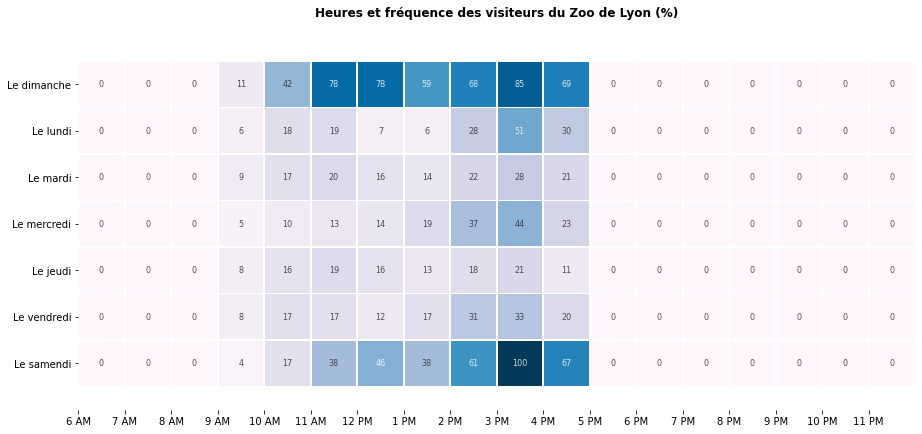

In [94]:
plt.figure(figsize=(15,7))
sns.heatmap(base, cmap='PuBu', linewidths=0.8, annot=True, annot_kws={'fontsize':8, 'alpha':0.8}, fmt='d', square=True,
           cbar=False)

plt.xticks(np.arange(18), list(base))
plt.title('Heures et fréquence des visiteurs du Zoo de Lyon (%)\n', weight='semibold')

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);
plt.show()

###  Il semble qu'en semaine c'est une meilleure option pour visiter notre Zoo, cependant le samedi de 14h à 16h ce lieu est très fréquentée.

## Conclusions

Du point de vue de l'intelligence de localisation pour la gestion de la destination touristique, les techniques utilisées permettent d'identifier et de localiser clairement les services, établissements et agents intéressés qui contribuent à améliorer l'image et la compétitivité de la ville de Lyon en tant que destination touristique et gastronomique.

Dans le domaine des implications managériales, les résultats générés par Google Maps et Popular Times nous offrent une option efficace pour conclure des accords B2B pour l'amélioration générale de la qualité des services et créer une expérience de voyage immersive liée aux technologies de marketing de proximité. . D'autre part, son application permet également d'identifier la fréquence à laquelle les lieux et / ou attractions sont visités, la compétition, leur popularité et les sujets pour lesquels ils sont reconnus en fonction des recommandations des utilisateurs.

Enfin, grâce aux résultats, il est possible d'appliquer ces techniques à n'importe quelle destination dans le monde et à n'importe quel secteur, par exemple en connaissant les heures de congestion dans les banques, les cabinets médicaux, le commerce de détail, etc., bien qu'il soit essentiel que la destination étudiée soit bien présente. dans Google Maps et que son afflux de visiteurs génère suffisamment d'interactions pour être analysées par le biais de la science des données.

# Références

<a href="http://www.patrimoine-lyon.org/traditions-lyonnaises/la-gastronomie-lyonnaise">1. Lyon - La Gastronomie Lyonnaise</a>

<a href="https://es.coursera.org/learn/applied-data-science-capstone">2. The Battle of Neighborhoods: Coursera Capstone Project</a>

<a href="https://github.com/mapbox/mapboxgl-jupyter">3. MapBox Location Data Visualization library for Jupyter Notebooks</a>

## 👍👍 <center> <a href="https://www.linkedin.com/in/lealrlx/">Partagez vos idées et vos commentaires, écrivez-moi 🌍 </a> </center>##